In [1]:
dataset_id = "11_highstat_settB_beamfocus"



# set data taking time in seconds for each step, minimum 90s is needed to initialize and get some trigger from dabc stream
data_taking_duration = 60*20

# MDC settings:
HVlist = [ 1650 ]

# set PASTTREC settings:
# peakintime: 10, 15, 20 (ns)
# gain: 1, 2, 4
# threshold: 1,2,3 .... 127
# spike rejection 10 ,15, 20 ,33,99 all int possible (ns)
####  SettingA :
# ptime_list = [ 10,15,20 ]
#pt_gain_list = [ 0,1,2,4  ]
# pt_gain_list = [ 2 ]
# pt_threshold_list = [10]
# spike_reject_list_TDC = [0]

####  SettingB :
ptime_list = [ 10 ]
pt_gain_list = [ 2 ]
pt_threshold_list = [ 5 ]
# spike_reject_list_TDC = [0]
####  SettingC :
# ptime_list = [ 10 ]
# pt_gain_list = [ 2  ]
# pt_threshold_list = [ 9 ]
# spike_reject_list_TDC = [0]

import os
# activate coincidence trigger only:
#os.system("trbcmd w 0xc035 0xa101 0xffff0800")
# activate scintillator1 trigger (ch49) only:
#os.system("trbcmd w 0xc035 0xa101 0xffff0400")  # trg_channel_mask: edge=1111 1111 1111 1111, mask=0000 0100 0000 0000

##################################
#ptime_list = [10]
# set PASTTREC default threshold for the measurement
# pt_gain_list = [ 2  ]
#pt_gain_list = [ 1,2,4]  
# pt_threshold_list = [2,5,7,9,12,15,20,30  ]
#pt_threshold_list = [5]
#pt_threshold_list = [5,7,9,11,13,15,17,19,21,23,25,27,40]
# pt_threshold_list = [7 ]
spike_reject_list = [0]
spike_reject_list_TDC = [0]
#spike_reject_list_TDC = [0,1,2,3,4,5,6,7,8]

#boards_scan_list =   [ "0902","0902","0902","0902"  ]
boards_scan_list =   [ "80053" , ]
if data_taking_duration < 90:
    data_taking_duration = 90
if data_taking_duration< 90:
    wait_for_beam = True
else:
    wait_for_beam = True
#time windows:
t1_min = -1500
t1_max = 0
#t1_min = -5000
#t1_max = 5000
#1. scintillator upstream
ref_channel = 35049
#2. scintillator downstream
#ref_channel = 35050

spillbreak_rate_scintillator = 3000
#board_list = [ "0900", "0901","0902","0903","0904", "0905","0906","0907"]
import db
board_list =  db.board_list(); 
boards_to_activate_on_one_step = 1
TDClist = ["0x1807","0x1812","0x1806","0x1813","0350"]
number_of_TDC_channels = 10
channellist = [48,49]
#time trend:
trendduration = 1*60*60
stepduration = 60

name = board_list[0]

#os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format("0x1800", 2))
#os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format("0x1803", 0))
# COSY May2021 beam position:
#os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format("0x1801", 0))
#os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format("0x1802", 2))
#setTDC spike rejection to ~50ns 
#os.system("trbcmd loadbit 0x1801 0xd580 0xf0000000 0x70000000")

#switch off DCDC converter nex to TDC1802 & 1803, which is there to check influence on noise
import hameg_lv as hMBO 

## define sequence of boards to activate in scan.
#boards_scan_list = board_list

total_measure_duration = data_taking_duration*len(spike_reject_list)*len(spike_reject_list_TDC)*len(ptime_list)*len(pt_gain_list)*len(pt_threshold_list)*len(boards_scan_list)/boards_to_activate_on_one_step*len(HVlist)
message = " total time estimated [h] = {:.2f} = [min] = {:.2f} ".format(total_measure_duration/3600,total_measure_duration/60)
print(message)


 total time estimated [h] = 0.33 = [min] = 20.00 


In [2]:
def beep(): 
    import IPython.display as ipd
    import numpy
    t = numpy.linspace(0, 0.5, int(0.6*24090), endpoint=False) # time variable
    x = 0.5*numpy.sin(2*numpy.pi*550*t)    
    ipd.Audio(x, rate=24090, autoplay=True) # load a NumPy array  


import ROOT
import os
from my_utils import *
set_width_max_of_jupyterpad()

from fst import *
import numpy as np
import db 
import pasttrec_ctrl as ptc
import baseline_calib

data_dir = make_data_dir()

#from ROOT import gInterpreter, gSystem
#gInterpreter.ProcessLine('#include "/workdir/my_event.h"')

import tdc_daq as td


print(data_dir)
for my_board in db.board_list():
    db.enable_board(my_board)    
    #db.unset_standby_board(my_board)
#     db.set_standby_board(my_board)    
    #db.disable_board(my_board)
#     ptc.init_board_by_name(my_board)
#     ptc.set_threshold_for_board_by_name(my_board,5)

ptc.init_active_boards()
td.enable_tdc_channels_of_active_boards()

#set spike rejection for pasttrec tdc channels:
#setup = db.get_setup_json()
#setup["global_settings"]["spike_rejection"] = 33
#print( setup["global_settings"]["spike_rejection"] )
#db.write_setup_json(setup)
#db.write_go4_settings_h()


Welcome to JupyROOT 6.14/04


/workdir/jupyter/Cosy2021Nov_tot_data_taking_data


In [3]:
##################################################
##   clear data dir, copy root file or measure fresh    ##
##################################################
import hameg_trb 
import os 
import time
import scalers
import IPython.display as ipd
import numpy
t = numpy.linspace(0, 0.5, int(0.6*24090), endpoint=False) # time variable
x = 0.5*numpy.sin(2*numpy.pi*550*t)    
        
# boards_scan_list = ['0110', '0011', '0010', '0015', '0016', '0009', '0017', '0020', '0023', '0030', '0110', '0029', '0002', '0027', '0101', '0025', '0004', '0026', '0022', '0003', '0014', '0021', '0018', '0104', '0006', '0028', '0103', '0102', '0008', '0005']
#boards_scan_list = ['0010', '0101', '0011', '0002', '0009', '0004', '0015', '0027', '0016', '0025', '0017', '0026', '0022', '0020', '0003', '0023', '0030', '0014', '0021', '0029', '0018', '0104', '0103', '0006', '0008', '0102', '0028']
#boards_scan_list = ['0010', '0011', '0009', '0015', '0016', '0017', '0020', '0023', '0030', '0029', '0101', '0002', '0004', '0027', '0025', '0026', '0022', '0003', '0014', '0021', '0018', '0104', '0006', '0028']
# boards_scan_list = ['0010', '0009', '0011', '0015', '0016', '0017', '0020', '0023', '0030', '0029', '0027', '0002', '0004', '0025', '0026', '0022', '0003', '0014', '0021', '0018', '0006', '0028', '0008', '0005']
#boards_scan_list = ['0014', '0005', '0021', '0022', '0025', '0003', '0026', '0027', '0008', '0004', '0002', '0101', '0029', '0030', '0028', '0023', '0020', '0017', '0016', '0006', '0015', '0010', '0011', '0009']

data_file_list = []
current_list = []
volt_list = []
current_list2 = []
volt_list2 = []

tdc_channels = list(range(0, number_of_TDC_channels))
scaler_list_trend_channel = [ []  for i in range(16)] 
scinti_rate = [[] for i in range(0,2)]
    
#for my_board in db.board_list():
#            db.unset_standby_board(my_board)
 
print(message)
alert(message)
#for timestep in range(0,ntimesteps):
for spike_reject in spike_reject_list:
 setup = db.get_setup_json()
 setup["global_settings"]["spike_rejection"] = spike_reject
 setup["global_settings"]["t1_L"] =     t1_min
 setup["global_settings"]["t1_R"] =     t1_max
 setup["global_settings"]["reference_channel"] =     ref_channel    
 db.write_setup_json(setup)
 db.write_go4_settings_h()

 for spike_reject_TDC in spike_reject_list_TDC:
 #setTDC spike rejection to ~50ns 
  os.system("trbcmd loadbit 0x1801 0xd580 0xf0000000 0x{:d}0000000".format(spike_reject_TDC))

  for HV in HVlist:
  # for tdc in TDClist:
      #  print("trbcmd loadbit {} 0xd580 0x300 0x{}00".format(tdc, ptime))
   #     os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format(tdc, ptime))
   for ptime in ptime_list: 
    for pt_gain in pt_gain_list:     
     for pt_threshold in pt_threshold_list:    
      for my_board in db.board_list():
        db.set_standby_board(my_board)
      import random
      random.shuffle(boards_scan_list)
      iboard = -boards_to_activate_on_one_step
      for p in range(0,int(len(boards_scan_list)/boards_to_activate_on_one_step)): 
        iboard += boards_to_activate_on_one_step
        
        #alert(message)
        import IPython.display as ipd
        import numpy
        t = numpy.linspace(0, 0.5, int(0.6*24090), endpoint=False) # time variable
        x = 0.5*numpy.sin(2*numpy.pi*650*t)    
        ipd.Audio(x, rate=24090, autoplay=True) # load a NumPy array
        time.sleep(5)
               
        for my_board in db.board_list():
            for p_act in range(0,boards_to_activate_on_one_step):
                if my_board == boards_scan_list[iboard+p_act]:
                    db.unset_standby_board(my_board)
                    db.enable_board(my_board)
                    print("activate board: ",my_board)
        # enable data taking boards:
#         print("enable data taking boards")
        for my_board in board_list:
            db.unset_standby_board(my_board)
            db.enable_board(my_board)
        td.enable_tdc_channels_of_active_boards()
       # ptc.init_boards_by_name(db.board_list())    
        #ptc.init_active_boards()
#         print("init")
        ptc.init_boards_by_name(board_list, ptime, pt_gain, pt_threshold)   
                        # init_boards_by_name(board_list,pktime=-1,gain=-1,threshold=-1):
#         print("threshold")        
        for name in board_list:
            #baseline_calib.set_baselines_individual(name, [-15]*16 )   
            ptc.set_threshold_for_board_by_name(name,pt_threshold)
        # startr measurements, with spill start:
        if wait_for_beam:
                wait_for_spill_break(threshold_rate=spillbreak_rate_scintillator)
                wait_for_spill(threshold_rate=spillbreak_rate_scintillator)
#         print(hameg_trb.get_curr(3), hameg_trb.get_curr(4))
        scaler_rates = td.scaler_rate_of_TDC("0x1807",tdc_channels,5) 
        for ch in range(0,len(scaler_rates)):
                    scaler_list_trend_channel[ch] += [ scaler_rates[ch] ]
        #scaler_rates = td.scaler_rate_of_board(name,2) 
        #tdc_daq.scaler_rate(TDC,channels,scan_time)[ch]
        #take_data(events=20000)
        # uses only trigger by TDC 0350 channel 49 as the reference. 
        # either Scitillator inpot or puls generator input to this channel, needs to be used
        beep()
        print("start data taking: HV_{:d}, peaking time_{:d}, threshold_{:d}, gain_{:d} # of boards active_{:d}, offline spike rejection_{:d}, TDC spike rejection_{:d}".format(HV,ptime,pt_threshold,pt_gain,iboard,spike_reject,spike_reject_TDC))
        import datetime
        now = datetime.datetime.now()
        print("Starting now {:s} ".format(str(datetime.datetime.now())))
        
#         upstream = scalers.scaler_rate("0x0350",[49],4)
#         downstream = scalers.scaler_rate("0x0350",[50],4)
        scaler_rates = td.scaler_rate("0x0350",channellist,30)
        for ch in range(0,len(scaler_rates)):
                scinti_rate[ch] += [ scaler_rates[ch] ]
        #print("beam intensity measured by scintillator rates: upstream ="+scinti_rate[0]+", downstream = "+downstream )
        startttime=datetime.datetime.now()
        print("Starting now {:s} ".format(str(datetime.datetime.now())))
        take_data(time=data_taking_duration)
        print("stopped now {:s} ".format(str(datetime.datetime.now())))
        print(datetime.datetime.now()-startttime)
        #import time as time
        #time.sleep(5) # prevents crashing the trbsystem (probably only needed with high traffic, while low thresholds ...) 

        ipd.Audio(x, rate=24090, autoplay=True) # load a NumPy array
        
        current_list += [ hameg_trb.get_curr(3) ]
        volt_list += [ hameg_trb.get_volt(3) ]
        current_list2 += [ hameg_trb.get_curr(4) ]
        volt_list2 += [ hameg_trb.get_volt(4) ] 

        print(hameg_trb.get_curr(3), hameg_trb.get_curr(4))
     # clear_data_dir()
        data_file = "{:s}/ID{:s}_HV{:d}V_ptime_{:d}_thr_{:d}_gain_{:d}_boardsON_{:d}_sr_{:d}_srTDC_{:d}.root".format(data_dir,dataset_id,HV,ptime,pt_threshold,pt_gain,iboard,spike_reject,spike_reject_TDC)
        print("data file written: ", data_file)
        #os.system("cp /workdir/tree_out.root {:s}".format(data_file))
        os.system("cp /workdir/joint_tree.root {:s}".format(data_file))
        data_file_list.append(data_file)

  # write data file list to disk, for later analysis
import pickle
with open("{:s}/datasetID_{:s}_list.pickle".format(data_dir,dataset_id), 'wb') as fp:
    pickle.dump(data_file_list, fp)  
print(fp)

 total time estimated [h] = 0.33 = [min] = 20.00 


activate board:  80053

## spill break ##

## spill start ##
start data taking: HV_1650, peaking time_10, threshold_5, gain_2 # of boards active_0, offline spike rejection_0, TDC spike rejection_0
Starting now 2021-11-05 16:02:50.006091 
Starting now 2021-11-05 16:03:20.086524 
stopped now 2021-11-05 16:26:48.399083 
0:23:28.312865
0.2517 1.861
data file written:  /workdir/jupyter/Cosy2021Nov_tot_data_taking_data/ID11_highstat_settB_beamfocus_HV1650V_ptime_10_thr_5_gain_2_boardsON_0_sr_0_srTDC_0.root
<_io.BufferedWriter name='/workdir/jupyter/Cosy2021Nov_tot_data_taking_data/datasetID_11_highstat_settB_beamfocus_list.pickle'>
GO4-*> Reading library: libGo4UserAnalysis  
GO4-*> Close of TUserSource  
GO4-*> Create default analysis with processor class TFirstStepProcessor  
GO4-*> Use class TStreamEvent as output event  
GO4-*> Welcome to Go4 Analysis Framework Release v6.0.1 (build 60001) !  
GO4-*> Analysis: Added analysis step Analysis  
GO4-*> Main: starting analysis in batch mode ..

>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reache

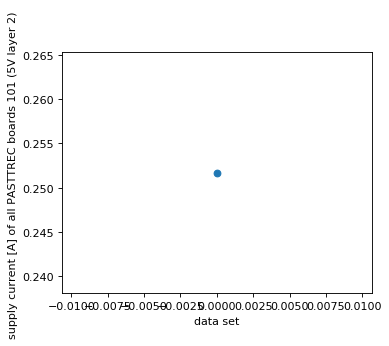

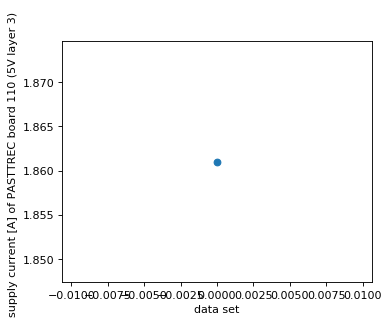

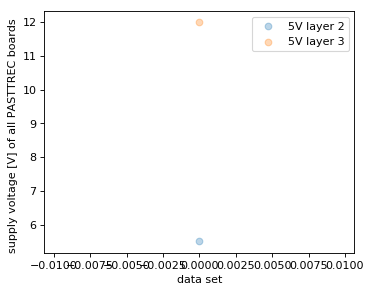

In [4]:

from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k')        
plt.scatter(range(0,len(current_list)),current_list)    
plt.xlabel("data set")
plt.ylabel("supply current [A] of all PASTTREC boards 101 (5V layer 2) ")
plt.show()
plt.figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k') 
plt.scatter(range(0,len(current_list2)),current_list2)        
plt.xlabel("data set")
plt.ylabel("supply current [A] of PASTTREC board 110 (5V layer 3) ")
plt.show()

plt.figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k') 
plt.scatter(range(0,len(volt_list)),volt_list,alpha=0.3,label = "5V layer 2")
plt.scatter(range(0,len(volt_list2)),volt_list2,alpha=0.3,label = "5V layer 3")      
plt.xlabel("data set")
plt.ylabel("supply voltage [V] of all PASTTREC boards  ")
plt.legend()
plt.show()

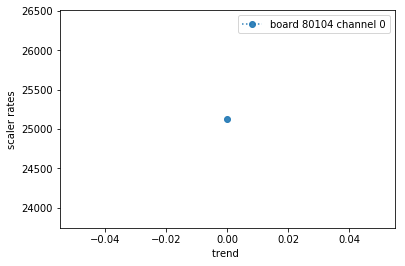

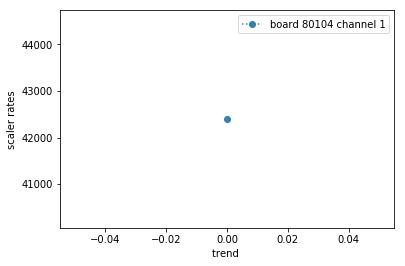

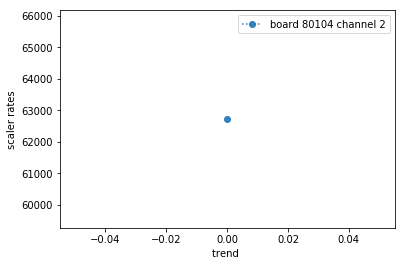

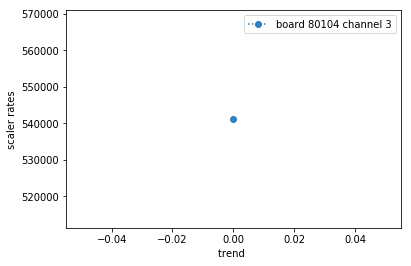

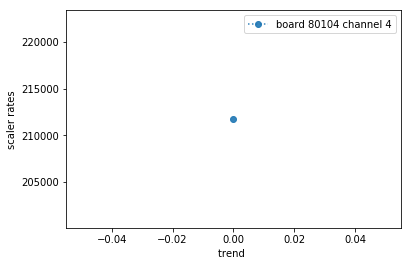

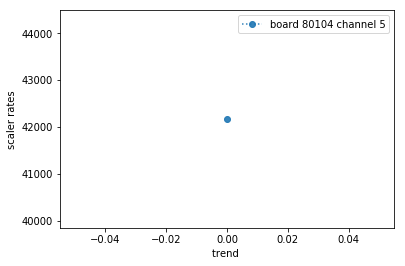

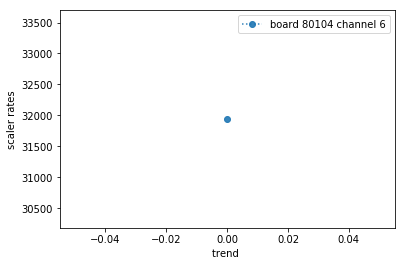

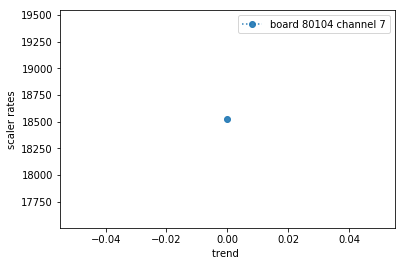

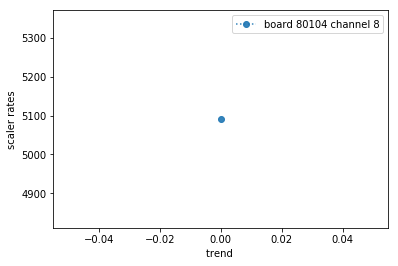

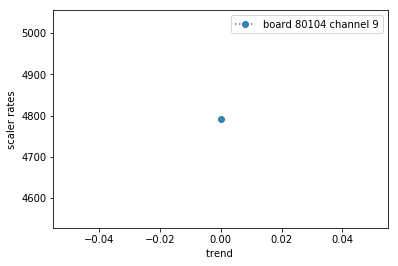

No handles with labels found to put in legend.


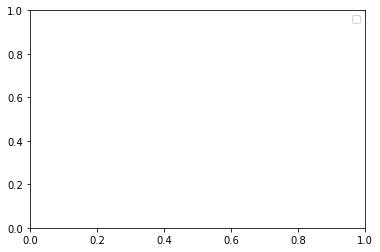

No handles with labels found to put in legend.


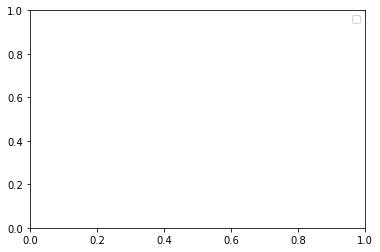

No handles with labels found to put in legend.


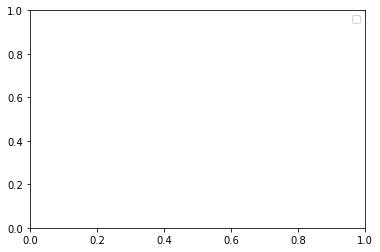

No handles with labels found to put in legend.


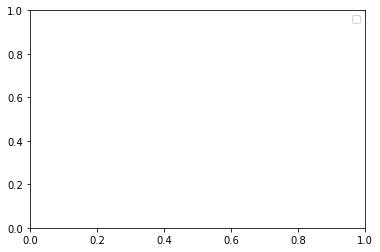

No handles with labels found to put in legend.


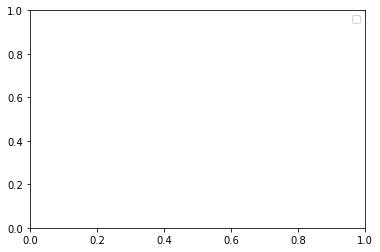

No handles with labels found to put in legend.


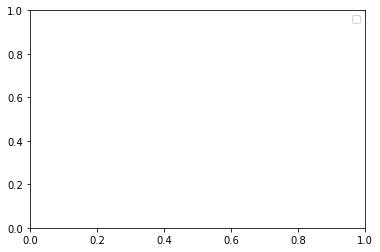

In [5]:
 
for ch in range(0,len(scaler_list_trend_channel)):
    if scaler_list_trend_channel[ch]:
            plt.errorbar(range(0,len(scaler_list_trend_channel[ch])),scaler_list_trend_channel[ch], yerr=None, xerr=None, fmt='o:', alpha=0.9,label = "board {:s} channel {:d}".format(name,ch))
            plt.xlabel("trend ")
            plt.ylabel("scaler rates")  
    plt.legend()
    plt.show()

In [6]:
  # write data file list to disk, for later analysis
import pickle 
with open("{:s}/datasetID_{:s}_list.pickle".format(data_dir,dataset_id), 'wb') as fp:
    pickle.dump(data_file_list, fp)  
print(fp)
alert("finished")
#data_file_list = pickle.load(fp) 

<_io.BufferedWriter name='/workdir/jupyter/Cosy2021Nov_tot_data_taking_data/datasetID_11_highstat_settB_beamfocus_list.pickle'>


In [7]:
# archive(label="ID_{:s}_tot_data_cosy2021_lena_newMBOs".format(dataset_id))


# list_file ="/workdir/jupyter/Cosy2021Nov_tot_data_taking_data/datasetID_06_b_hvscan_SettingB_highintens_list.pickle"

# if ".pickle" in list_file:
#     with open (list_file,'rb') as fp:
#      data_file_list = pickle.load(fp) 
# # print(data_file_list)

# list_file ="/workdir/jupyter/Cosy2021Nov_tot_data_taking_data/datasetID_06_hvscan_SettingB_highintens_list.pickle"

# if ".pickle" in list_file:
#     with open (list_file,'rb') as fp:
#      data_file_list += pickle.load(fp) 
    
# print(data_file_list)

In [ ]:

##################################################
##               slurp root file                ##
##################################################
 
#with open ('/workdir/jupyter/tot_data_taking_data/HV1600V_ptime_15_threshold_50_gain_4_boardsON_23.rootlist.pickle', 'rb') as fp:

counts=[]

#f = ROOT.TFile("/workdir/tree_out.root".format(data_dir))
#tree = f.Get("TDC_1503")
#print("data entries TDC_1503: " + str(tree.GetEntries()))
i = -1
clist = [None]*100
print("data file   ,", "tot_mostprob", "signalcounts", "noisecounts", "sn_ratio", "significance")
    
for data_file in data_file_list:
    i += 1
    print(data_file)
    f = ROOT.TFile("{:s}".format(data_file))
    #f = ROOT.TFile("{:s}".format("/workdir/tree_out.root"))    
    tree = f.Get("joint_tree")
    #tree = f.Get("TDC_1800")
    #print("data entries: " + str(tree.GetEntries()))
    ## plot data:
    clist[i] = ROOT.TCanvas("myCanvasName"+str(i),str(data_file),1600,600)
    clist[i].Divide(2,1)
    clist[i].cd(1)    
    #tree.Draw("tot>>htot(300,0,300)","chan > 150300 && chan < 150316")
    #tree.Draw("tot>>htot2(300,0,300)","chan > 035300 && chan < 035316","same")   
    tree.Draw("tot>>htot3(300,0,1000)","chan == 180704") 
    tree.Draw("tot>>htot2(300,0,1000)","chan == 181305") 
    #tree = f.Get("TDC_1503")
    #tree.Draw("tot>>htot(300,0,1000)","chan > 00") 
    #tree.Draw("tot>>htot3(100,0,600)","chan > 180000 && chan < 180099")  
    #tree.Draw("tot>>htot2(100,0,600)","chan > 180100 && chan < 180199") 
    #tree.Draw("tot>>htot3(100,0,600)","chan > 180200 && chan < 180299") 
    #tree.Draw("tot>>htot2(100,0,600)","chan > 180300 && chan < 180399")  
    #tree.Draw("tot>>htot3(100,0,600)","chan > 0") 
    #tree.Draw("tot>>htot4(100,0,600)","chan > 150300 && chan < 150399")    
    tree.Draw("tot>>htot4(300,0,1000)","chan == 181305") 
    tree.Draw("tot>>htot(100,0,300)","chan == 180706")
    clist[i].Draw()
    htot = f.Get("htot")
    htot2 = f.Get("htot2")
    htot3 = f.Get("htot3")
    htot4 = f.Get("htot4")    
    
    htot.GetXaxis().SetTitle("ToT [ns]")
    htot.GetYaxis().SetTitle("counts")
    leg = ROOT.TLegend(.73,.32,.97,.53)
    leg.SetBorderSize(0)
    leg.SetFillColor(0)
    leg.SetFillStyle(0)
    leg.SetTextFont(42)
    leg.SetTextSize(0.035)
    leg.AddEntry(htot,htot.GetTitle());
    leg.AddEntry(htot2,htot2.GetTitle());
    leg.AddEntry(htot3,htot3.GetTitle());
    leg.AddEntry(htot4,htot4.GetTitle());     
    
    htot.SetTitle(data_file.strip("workdir/jupyter/tot_data_taking_data"))
    htot2.SetLineColor(6)
    htot.SetMinimum(0.1)
    htot.DrawCopy("")
    htot2.DrawCopy("same")
    htot3.SetLineColor(7)
#     htot3.DrawCopy("e p0 same")
    htot4.SetLineColor(8)
    #htot4.DrawCopy("e p0 same")
   # tree.Draw("trig_no>>triggmdc(100,0,1e9)","") 
    #triggmdc = f.Get("triggmdc")
    #trigcounts =(triggmdc.GetEntries())
  #  triggmdc.DrawCopy("colz")
    
    leg.Draw();
    #clist[i].cd(1).SetLogy()

    fish = f.Get("meta_fish")
    fish = f.Get("0x1807_potato")
    #fish.GetXaxis().SetRangeUser(-200,100)
    #fish.GetYaxis().SetRangeUser(50,500)
    fish.DrawCopy("colz")
    clist[i].Draw()
    clist[i].cd(2)      
    tdc=1807
    disp_channels = 10
    tree.Draw("tot:t1>>tot_meta(100,-700,0,300,-10,400)","chan>{:d} && chan<{:d}".format(tdc*100,tdc*100+disp_channels),"colz")
    potato = f.Get("tot_meta")
    potato.DrawCopy("colz")
   
#     fish = f.Get("meta_fish")
    fish = f.Get("0x1807_potato")
    fish.GetXaxis().SetRangeUser(-200,100)
    fish.GetYaxis().SetRangeUser(50,500)
#     counts.append(fish.GetEntries())
    
    fish.DrawCopy("colz")
#
 #   tree.Draw("trig_no>>triggmdc(100,0,1e9)","chan == 180706") 
  #  triggmdc = f.Get("triggmdc")
   # counts.append(triggmdc.GetEntries()/trigcounts)
    #triggmdc.DrawCopy("colz")
    clist[i].Draw()
    
    
    tot_mostprob = htot.GetXaxis().GetBinCenter(htot.GetMaximumBin())
    
    signalcounts  = htot.Integral(htot.FindBin(40),htot.GetNbinsX())
    noisecounts   = htot.Integral(1,htot.FindBin(40))
    if noisecounts == 0:
        sn_ratio = -1
        significance = -1
    else:
        sn_ratio = signalcounts/noisecounts
        significance = signalcounts/np.sqrt(signalcounts+noisecounts)
    print(  htot.GetTitle() , "| ",  tot_mostprob,"| ", signalcounts,"| ", noisecounts,"| ", "{:.2f}".format(sn_ratio),"| ", "{:.2f}".format(significance))
    
    
    print(  htot.GetTitle() , "| ",  tot_mostprob,"| ", signalcounts,"| ", noisecounts,"| ", "{:.2f}".format(sn_ratio),"| ", "{:.2f}".format(significance))


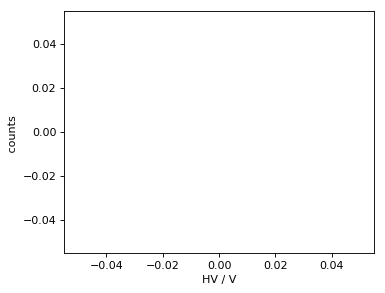

In [9]:
plt.figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k') 
plt.scatter(range(0,len(counts)),counts)
plt.xlabel("HV / V")
plt.ylabel(" counts  ")
 


plt.show()

In [10]:
tot_mostprob = htot.GetXaxis().GetBinCenter(htot.GetMaximumBin())
    
signalcounts  = htot.Integral(htot.FindBin(40),htot3.GetNbinsX())
noisecounts   = htot.Integral(1,htot.FindBin(40))
print(signalcounts)
signalcounts2  = htot2.Integral(htot2.FindBin(40),htot2.GetNbinsX())
noisecounts2   = htot2.Integral(1,htot2.FindBin(40))
print(signalcounts2)
print(signalcounts/signalcounts2)
print(noisecounts/noisecounts2)

56228.0
5414.0
10.385666789804212
16.93058201058201


In [11]:

c = ROOT.TCanvas("correl","correlations",640,480) 

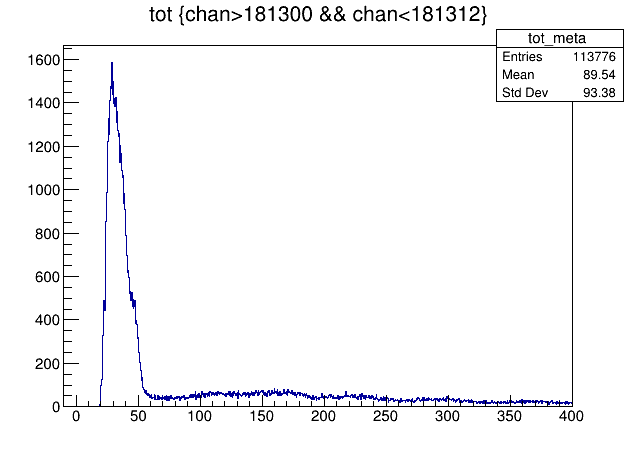

In [12]:
tdc=1813
disp_channels = 12
tree.Draw("tot>>tot_meta(1000,-10,400)","chan>{:d} && chan<{:d}".format(tdc*100,tdc*100+disp_channels))
c.Draw()

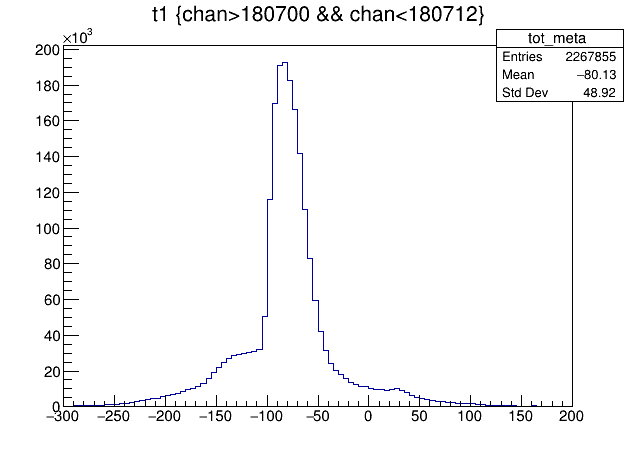

In [13]:
tdc=1807
disp_channels = 12
tree.Draw("t1>>tot_meta(100,-300,200)","chan>{:d} && chan<{:d}".format(tdc*100,tdc*100+disp_channels))
c.Draw()

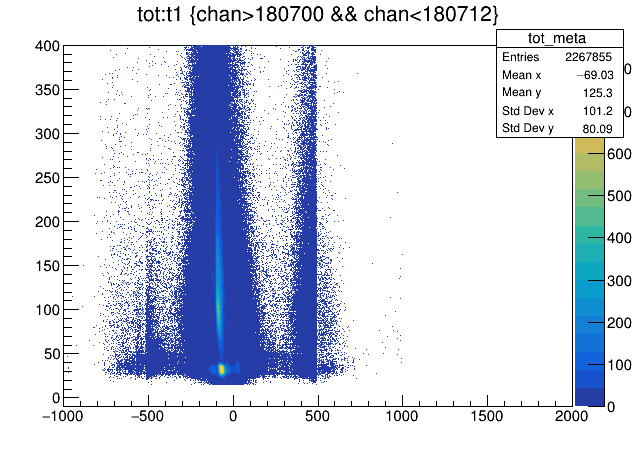

In [14]:
tdc=1807
disp_channels = 12
tree.Draw("tot:t1>>tot_meta(1000,-1000,2000,1000,-10,400)","chan>{:d} && chan<{:d}".format(tdc*100,tdc*100+disp_channels),"colz")
c.Draw()

In [ ]:
tdc=1813
disp_channels = 10
tree.Draw("tot:t1>>tot_meta(1000,-1000,2000,1000,-10,400)","chan>{:d} && chan<{:d}".format(tdc*100,tdc*100+disp_channels),"colz")
c.Draw()

In [ ]:
tree.Draw("tot:t1>>tot_meta(300,-100,500,1000,-10,40)","chan>{:d} && chan<{:d}".format(0,5000000),"colz")
c.Draw()

In [ ]:

tdc=1813
disp_channels = 12
#tree.Draw("chan:t1","","lego2")
tree.Draw("chan:tot>>tot_meta(1000,-300,800,{:d},{:d},{:d})".format(disp_channels,tdc*100,tdc*100+disp_channels),"","colz")
c.Draw()

In [ ]:
##################################################
##             overview TDC 0x0351              ##
##################################################
c = ROOT.TCanvas("myCanvasName","The Canvas Title",640,480)

tdc=1802
disp_channels = 12
#tree.Draw("chan:t1","","lego2")
tree.Draw("chan:t1>>tot_meta(1000,-500,300,{:d},{:d},{:d})".format(disp_channels,tdc*100,tdc*100+disp_channels),"","colz")
c.Draw()

In [ ]:
plt.figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k') 
plt.scatter(range(0,len(scinti_rate[0])),scinti_rate[0],alpha=0.5,label = "scintillator behind MDC")
plt.scatter(range(0,len(scinti_rate[1])),scinti_rate[1],alpha=0.5,label = " MDC cell in beam center")
plt.xlabel("data set")
plt.ylabel
plt.ylabel(" scintillator rate / Hz ")
# plt.yscale('log')
plt.legend()

plt.savefig('{:s}/ID_{:s}_tot_data_cosy2021_lena_beam_intensity.png'.format(data_dir,dataset_id), dpi=100)
plt.show()
print(scinti_rate)


In [ ]:
import IPython.display as ipd
import numpy
t = numpy.linspace(0, 0.5, int(0.6*24090), endpoint=False) # time variable
x = 0.5*numpy.sin(2*numpy.pi*550*t)    
ipd.Audio(x, rate=24090, autoplay=True) # load a NumPy array

#### 

In [ ]:

archive(label="ID_{:s}_tot_data_cosy2021_sandra_oldTDC".format(dataset_id))
